## **MODEL'S PIPELINE**

### **GENERAL IMPORTS**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

### **DATA**

In [50]:
data_model = pd.read_csv("data/processed/data_model.csv")

data_model["gender"] = data_model["gender"].astype("category")
data_model["registered_on"] = pd.to_datetime(data_model["registered_on"])

data_model = data_model.sort_values("registered_on").reset_index(drop=True)

print(data_model.shape)
data_model.head()

(63288, 41)


,account_id,offer_id,duration,min_value,discount_value,avg_days_between_received_view,n_canais,offer_type_bogo,offer_type_discount,offer_type_informational,...,pct_type_bogo,pct_type_discount,pct_type_informational,pct_viewed_offers,pct_completed_offers,pct_channel_email,pct_channel_mobile,pct_channel_social,pct_channel_web,target
0,77388a70eaf14433b4efc5d01fa947bf,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,3.0,1.625,4,False,True,False,...,0.4,0.6,0.0,0.8,1.0,1.0,0.8,0.8,0.8,0
1,77388a70eaf14433b4efc5d01fa947bf,ae264e3637204a6fb9bb56bc8210ddfd,7.0,10.0,10.0,1.625,3,True,False,False,...,0.4,0.6,0.0,0.8,1.0,1.0,0.8,0.8,0.8,1
2,77388a70eaf14433b4efc5d01fa947bf,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.625,4,True,False,False,...,0.4,0.6,0.0,0.8,1.0,1.0,0.8,0.8,0.8,0
3,77388a70eaf14433b4efc5d01fa947bf,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,2.0,1.625,4,False,True,False,...,0.4,0.6,0.0,0.8,1.0,1.0,0.8,0.8,0.8,1
4,77388a70eaf14433b4efc5d01fa947bf,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,20.0,5.0,1.625,2,False,True,False,...,0.4,0.6,0.0,0.8,1.0,1.0,0.8,0.8,0.8,1


In [51]:
# Conferindo unicidade
data_model[["account_id", "registered_on"]].drop_duplicates()["account_id"].duplicated().any()

False

In [59]:
# Separando dados de treino e teste a partir da data de registro dos clientes
# Respeitar a natureza evolutiva do comportamento dos clientes e evitar vazamento temporal
# (ex: resultados de campanhas futuras)
dtrain = data_model[data_model["registered_on"] < "2018-06-01"]
dtest = data_model[data_model["registered_on"] >= "2018-06-01"]

dtrain.shape, dtest.shape

((59280, 41), (4008, 41))

### **FEATURES**

In [131]:
FEATURES = [
    "duration", 
    "min_value", 
    "discount_value",
    "avg_days_between_received_view",
    "n_canais",
    "offer_type_bogo",
    "offer_type_discount",
    "offer_type_informational",
    "event_2-offer_viewed",
    # "event_3-offer_completed", 
    # "event_4-transaction", 
    "channels_email",
    "channels_mobile",
    "channels_social", 
    "channels_web", 
    "age",
    "gender",
    "credit_card_limit",
    # "n_offers", # Verificar essa feature. Parece estar contando pós preenchimento. Garantir que esteja contando apenas o número de `event_1-offer received`.
    "unique_offers",
    # "avg_ticket",
    # "total_amount",
    "days_to_first_interaction",
    "day_of_last_interaction",
    "avg_days_offers_received",
    "avg_days_offers_viewed",
    # "avg_days_offers_completed", 
    "pct_type_bogo",
    "pct_type_discount",
    "pct_type_informational",
    "pct_viewed_offers",
    # "pct_completed_offers",
    "pct_channel_email",
    "pct_channel_mobile",
    "pct_channel_social",
    "pct_channel_web",
]
TARGET = "target"

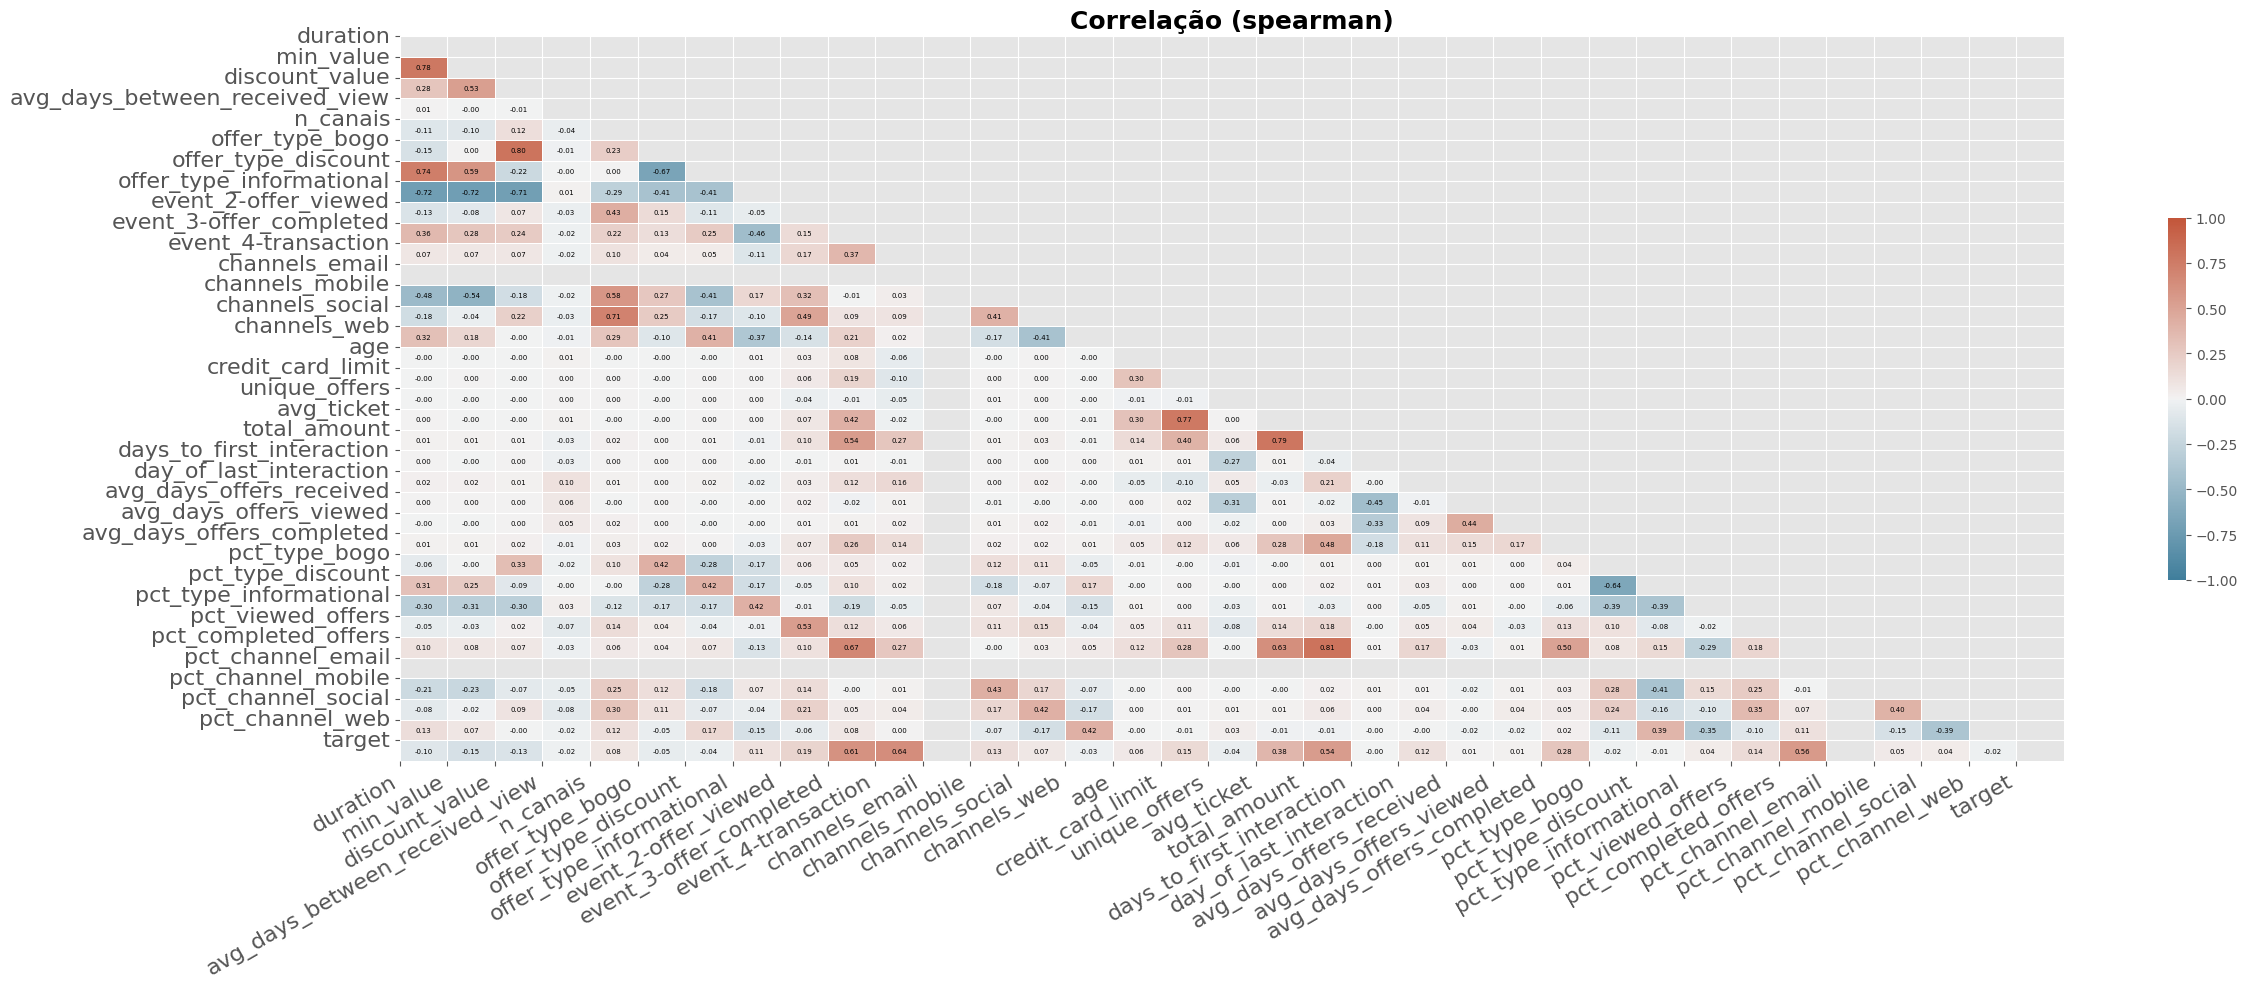

In [57]:
from src.plots import plot_corr
plot_corr(data_model[FEATURES + [TARGET]], method="spearman")

### **FEATURE SELECTION**

2025-05-11 16:53:33.772 | INFO     | src.utils:feature_selection:212 - Train AUC: 0.8195
2025-05-11 16:53:33.772 | INFO     | src.utils:feature_selection:213 - Valid AUC: 0.7138
2025-05-11 16:53:41.780 | SUCCESS  | src.utils:feature_selection:238 - POSITIVE IMPORTANCE:
2025-05-11 16:53:41.780 | SUCCESS  | src.utils:feature_selection:240 - 0.037893: event_2-offer_viewed
2025-05-11 16:53:41.780 | SUCCESS  | src.utils:feature_selection:240 - 0.037440: age
2025-05-11 16:53:41.780 | SUCCESS  | src.utils:feature_selection:240 - 0.034771: credit_card_limit
2025-05-11 16:53:41.780 | SUCCESS  | src.utils:feature_selection:240 - 0.026385: duration
2025-05-11 16:53:41.781 | SUCCESS  | src.utils:feature_selection:240 - 0.022966: day_of_last_interaction
2025-05-11 16:53:41.781 | SUCCESS  | src.utils:feature_selection:240 - 0.021278: discount_value
2025-05-11 16:53:41.781 | SUCCESS  | src.utils:feature_selection:240 - 0.011887: gender
2025-05-11 16:53:41.781 | SUCCESS  | src.utils:feature_selection:

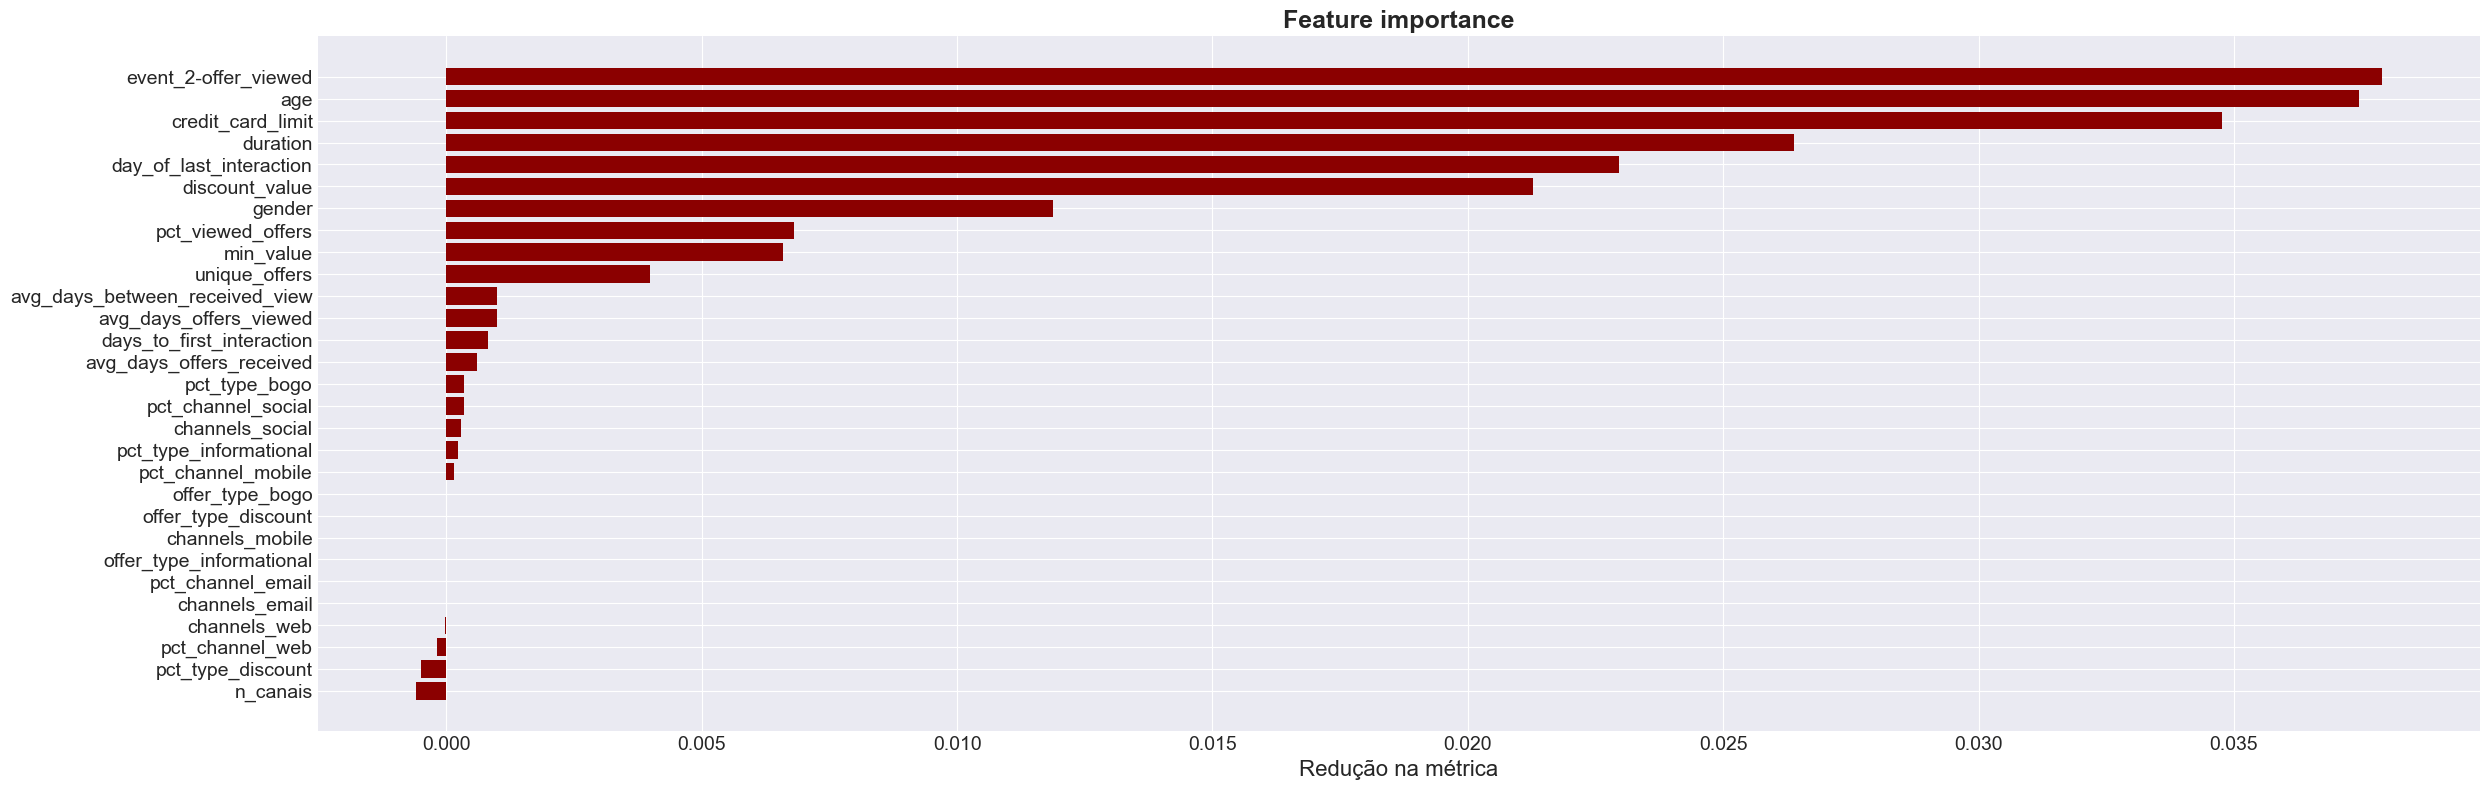

In [158]:
from src.utils import feature_selection
SELECTED_FEATURES = feature_selection(
    data=dtrain, features=FEATURES, target=TARGET
)

In [159]:
SELECTED_FEATURES

['event_2-offer_viewed',
 'age',
 'credit_card_limit',
 'duration',
 'day_of_last_interaction',
 'discount_value',
 'gender',
 'pct_viewed_offers',
 'min_value',
 'unique_offers',
 'avg_days_between_received_view',
 'avg_days_offers_viewed',
 'days_to_first_interaction',
 'avg_days_offers_received',
 'pct_type_bogo',
 'pct_channel_social',
 'channels_social',
 'pct_type_informational',
 'pct_channel_mobile',
 'offer_type_bogo']

### **MODEL**

#### **Optimization**

In [160]:
from src.hyperopt import RollingWindowOptimizer
optmizer = RollingWindowOptimizer(
    data=dtrain,
    features=SELECTED_FEATURES,
    target=TARGET,
    n_folds=5,
    trials=20
)
optmizer.run()

2025-05-11 16:54:40.591 | INFO     | src.hyperopt:run:26 -  Optimizing...
2025-05-11 16:54:41.786 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 1: Logloss=0.56177 (σ=0.00249) | AUC=0.74665 (σ=0.00153) | Brier=0.18676 (σ=0.00055)
2025-05-11 16:54:42.431 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 2: Logloss=0.57041 (σ=0.00218) | AUC=0.73836 (σ=0.00172) | Brier=0.18864 (σ=0.00059)
2025-05-11 16:54:43.223 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 3: Logloss=0.55094 (σ=0.00258) | AUC=0.74687 (σ=0.00146) | Brier=0.18687 (σ=0.00053)
2025-05-11 16:54:43.912 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 4: Logloss=0.57303 (σ=0.00213) | AUC=0.74628 (σ=0.00153) | Brier=0.18696 (σ=0.00054)
2025-05-11 16:54:44.248 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 5: Logloss=0.56571 (σ=0.00235) | AUC=0.73282 (σ=0.00167) | Brier=0.18927 (σ=0.00060)
2025-05-11 16:54:45.077 | SUCCESS  | src.hyperopt:train:109 -  TRIAL 6: Logloss=0.56341 (σ=0.00317) | AUC=0.74215 (σ=0.00175) | Brier=0.18756 (σ=0.00059)
20

In [162]:
best_params = optmizer.best_params
best_params

{'max_depth': 4,
 'num_leaves': 9,
 'n_estimators': 100,
 'learning_rate': 0.09,
 'pos_bagging_fraction': 0.5663961305785377,
 'neg_bagging_fraction': 0.8764347463731476,
 'bagging_freq': 7}

#### **Traning**

In [97]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

from src.utils import get_baseline_logloss

params = {"n_estimators": 60}

n_splits = 5
X, y = dtrain[FEATURES], dtrain[TARGET]

tscv = TimeSeriesSplit(n_splits=n_splits)

brier_scores = []                   # para avaliar a calibração
auc_scores, logloss_scores = [] ,[] # para avaliar o modelo

for fold, (train_index, valid_index) in enumerate(tscv.split(X)):
    print(f"\n=== Fold {fold + 1}/{n_splits} ===")

    X_train, X_temp = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_temp = y.iloc[train_index], y.iloc[valid_index]

    # Separando um conjunto para testar a calibração
    split_point = int(len(X_temp) * 0.7)
    X_calib, X_valid = X_temp.iloc[:split_point], X_temp.iloc[split_point:]
    y_calib, y_valid = y_temp.iloc[:split_point], y_temp.iloc[split_point:]

    model = LGBMClassifier(**params, force_row_wise=True, verbosity=0)
    model.fit(X_train, y_train)

    # Calibrando o modelo
    model_calib = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
    model_calib.fit(X_calib, y_calib)

    preds = model_calib.predict_proba(X_valid)[:, 1]

    logloss = log_loss(y_valid, preds)
    auc = roc_auc_score(y_valid, preds)
    brier = brier_score_loss(y_valid, preds)

    auc_scores.append(auc)
    brier_scores.append(brier)
    logloss_scores.append(logloss)

    get_baseline_logloss(y=y_valid)
    print(f"LogLoss: {logloss:.4f} | AUC: {auc:.4f} | Brier: {brier:.4f}")

    # # Plota curva de calibração (apenas para o último fold)
    # if fold == n_splits - 1:
    #     prob_true, prob_pred = calibration_curve(y_valid, preds, n_bins=10)
    #     plt.figure(figsize=(6, 6))
    #     plt.plot(prob_pred, prob_true, marker='o', label='Modelo Calibrado')
    #     plt.plot([0, 1], [0, 1], '--', label='Ideal')
    #     plt.xlabel('Probabilidade prevista')
    #     plt.ylabel('Frequência observada')
    #     plt.title('Curva de calibração - Último Fold')
    #     plt.legend()
    #     plt.grid()
    #     plt.show()



=== Fold 1/5 ===


2025-05-11 13:02:54.759 | INFO     | src.utils:get_baseline_logloss:170 - Baseline LogLoss=0.6194


LogLoss: 0.0999 | AUC: 0.9917 | Brier: 0.0277

=== Fold 2/5 ===


2025-05-11 13:02:54.995 | INFO     | src.utils:get_baseline_logloss:170 - Baseline LogLoss=0.6205


LogLoss: 0.0948 | AUC: 0.9927 | Brier: 0.0272

=== Fold 3/5 ===


2025-05-11 13:02:55.245 | INFO     | src.utils:get_baseline_logloss:170 - Baseline LogLoss=0.6891


LogLoss: 0.0684 | AUC: 0.9967 | Brier: 0.0191

=== Fold 4/5 ===


2025-05-11 13:02:55.538 | INFO     | src.utils:get_baseline_logloss:170 - Baseline LogLoss=0.6865


LogLoss: 0.0825 | AUC: 0.9955 | Brier: 0.0245

=== Fold 5/5 ===


2025-05-11 13:02:55.813 | INFO     | src.utils:get_baseline_logloss:170 - Baseline LogLoss=0.6325


LogLoss: 0.0691 | AUC: 0.9966 | Brier: 0.0206
